# Simulation of brownian particles through a pore

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from brownpy import Universe
from brownpy.topology import ElasticPore1

## Define simulation setup

In [2]:
N_particles = 8*1024 # Number of particles (power of 2 is better for gpu)
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient
dt = 1e6 # fs (1ns) - Time step
seed = 1789 # Specify seed for reproductibility. The same seed is used
# for filling randomly the geometry and for random walk dynamic.

# Define topology
# Geometry inspired from Marbach 2020
# J. Chem. Phys. 154, 171101 (2021); doi: 10.1063/5.0047380

#     ┃         ┃         ┃     ↑  
#     ┃         ┃         ┃     │ Lm
#     ┃         ┃         ┃     │
#     ┃           ↕2R     ┃     ╵ 
#     ┃         ┃         ┃     
#     ┃         ┃         ┃     
#     ┃         ┃         ┃     
#      ←-----------------→
#      
R = 10 # A (1nm) - Height of the pore
Lm = 1000 # A (100nm) - Distance between each pores
L = 1E4 # A (1um) - Reservoir depth 
top = ElasticPore1(Lm, L, R, seed=seed)

# Define simulation setup
u = Universe(top, N_particles, D, dt,
             output_path='elasticPore', overwrite=True)

## Plotting initial configuration

(-300.0, 300.0)

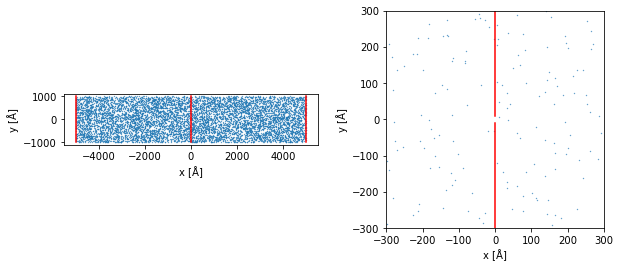

In [3]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
u.plot(axes[0])
u.plot(axes[1])
axes[1].set_xlim(-300, 300)
axes[1].set_ylim(-300, 300)

## Watching particle trajectory

In [4]:
# Be carefull ! Here it will already generate 68MB of data !
# First step of the first run is always slow since we compiled the engine
# just in time. 
u.run(10_000, freq_dumps=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------
GPU timing :
Allocation: 3.93 ns/dt/p
Engine: 16.1 ns/dt/p
Transfert to RAM: 450 ps/dt/p
Total: 20.5 ns/dt/p
------------------------------------------
CPU timing:
Transfert to drive: 2.4 ns/dt/p
Total: 22.9 ns/dt/p
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 22.9  s



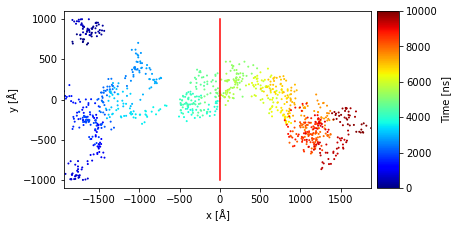

In [5]:
# Retrieving trajectory from output file and plot it
traj = u.f['/run/0/trajectory']
x = traj[:,0]

# Getting index of particles that go through the pore
temp = np.argsort(np.sum(x<0, axis=1)*np.sum(x>0, axis=1))[::-1]
 
fig, ax = plt.subplots()
top.plot(ax)
i_particle = temp[1]
x, y = traj[i_particle,0,:], traj[i_particle,1,:]
ax.scatter(x, y, c=np.arange(traj.shape[2]), marker='.', cmap='jet', s=4)
ax.set_aspect('equal')
ax.set_xlim(x.min(), x.max())

# Colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=10_000*u.dt/1E6)
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="2%")
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.jet,norm=norm,)
cb1.set_label('Time [ns]')

## Show number of particles in specific region of space

In [6]:
# Since we do not record trajectory we can make a longer simulation
u.run(1_000_000)

  0%|          | 0/1000000 [00:00<?, ?it/s]

------------------------------------------
GPU timing :
Allocation: 496 fs/dt/p
Engine: 871 ps/dt/p
Transfert to RAM: 405 fs/dt/p
Total: 872 ps/dt/p
------------------------------------------
CPU timing:
Transfert to drive: 2.86 ps/dt/p
Total: 875 ps/dt/p
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 875 ms



In [7]:
# In-built topology has regions already defined by defaut.
# However, you can specify it in 'run' function argument 
top.regions

[{'name': 'left', 'def': 'x<=0'}]

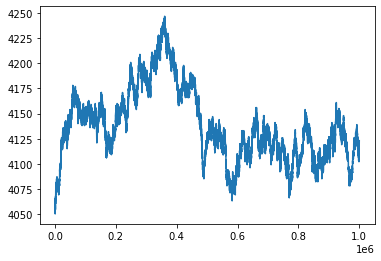

In [8]:
# Let's plot it
left = u.f['/run/1/regions/left']
plt.plot(left)